# Analysis notebook

## Motivations and goals
The goal of this project is to predict the survivality of people on the Titanic, using different models.

We selected the following 3 questions:

1. sd
2. sd
3. sd

In [34]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import pylab 
import scipy.stats as stats
import seaborn as sns

## Step 0: Import the files

We import the files train.csv and test.csv, put them together to make sure they have the same levels. We will pre-process the data on the full dataset to simplify this analysis.

In [6]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
test['SalePrice'] = np.nan

df = pd.concat(
    [
        train,
        test 
    ],
    axis = 0,
    ignore_index= True
)
print(train.shape)
print(test.shape)
print(df.shape)

(1460, 81)
(1459, 81)
(2919, 81)


In [7]:
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

We keep the Id column for now, but it will be removed later on.

## Step 1 - EDA

### 1.1 Exploring the output column

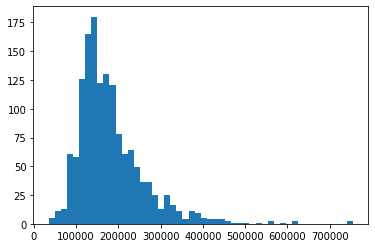

In [12]:
# histogram of SalePrice
plt.hist(
    df['SalePrice'],
    bins = 50
);

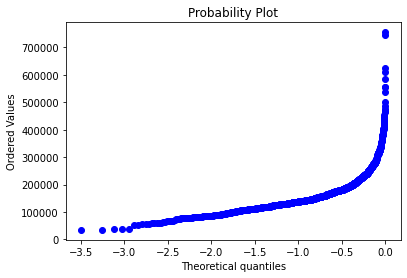

In [14]:
# qq plot
stats.probplot(
    df['SalePrice'],
    dist="norm",
    plot=pylab
)
pylab.show()

We see that the SalePrice column has a right tail. Let's log the predictions to have a normally distributed target.


In [15]:
# let's log transform the SalePrice column
df['SalePrice'] = np.log(df['SalePrice'])

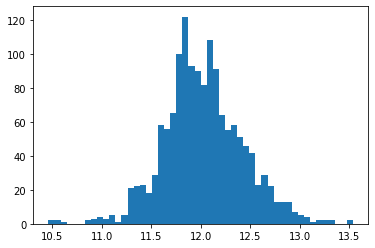

In [16]:
# histogram of SalePrice
plt.hist(
    df['SalePrice'],
    bins = 50
);

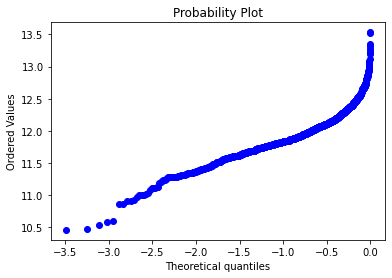

In [17]:
# qq plot
stats.probplot(
    df['SalePrice'],
    dist="norm",
    plot=pylab
)
pylab.show()

We see that 5 sales have very low SalePrices and 2 very high ones.

After short investigation, we can see that the 5 houses with low SalePrice are very old houses (built before 1950) of below average general condition and usually with an abnormal sale condition.

As for the 2 rows with very high SalePrice, they were built around 1994-6, with overall excellent condition for each check done (Garages, rooms, Kitchen, etc). One even has a pool.

We do not consider these 7 profiles as outliers, and will keep them in the analysis.

### 1.2 Missing values

Let's first look at the columns with missing values:

In [20]:
# check missing values
missing_vals = df.isna().sum()[df.isna().sum()>0]

In [21]:
print(
    f"""
    {len(missing_vals)} predictors have missing values, and SalePrice is missing {missing_vals["SalePrice"]} times, as expected.
    """
)


    35 predictors have missing values, and SalePrice is missing 1459 times, as expected.
    


Let's look at each of these predictors with missing variable, group by group, to try to understand the best way to fill them.

#### 1.2.1 Pool variables

In [23]:
print(
    f"""PoolQC is pool quality, where NA means in theory "no pool". It is an ordered factor with {np.round(missing_vals['PoolQC']/df.shape[0]*100,4)}% of NAs.  It is an ordered variable.
""")

PoolQC is pool quality, where NA means in theory "no pool". It is an ordered factor with 99.6574% of NAs.  It is an ordered variable.

There is another variable called PoolArea, for the area of the pool. When we look at the area if there is a pool or not, we see that the area is most of the time 0 if there is no pool.



In [25]:
df[df['PoolQC'].isna()]['PoolArea'].value_counts()

0      2906
368       1
444       1
561       1
Name: PoolArea, dtype: int64

There is another variable called PoolArea, for the area of the pool. When we look at the area if there is a pool or not, we see that the area is most of the time 0 if there is no pool.

We will add "No" as a level, and replace all NAs that have 0 as area by "No". the NAs with PoolArea>0 will be filled based on the Overall quality of the house: 

- if OverallQual is <= 2, returns "Po"
- else, if OverallQual is <= 4, returns "Fa"
- else, if OverallQual is <= 6, returns "TA"
- else, if OverallQual is <= 8, returns "Gd"
- else, returns "Ex"

In [31]:
df['PoolQC'] = df['PoolQC'].map(str)
df['overall_fac'] = np.select(
    [
        df['OverallQual'] <= 2,
        df['OverallQual'] <= 4,
        df['OverallQual'] <= 6,
        df['OverallQual'] <= 8
    ],
    [
        'Po','Fa','TA','Gd'
    ],
    'Ex'
)
df['PoolQC'] = np.select(
    [
        (df['PoolQC'].isna()) & ( df['PoolArea'] > 0 ),
        (~ df['PoolQC'].isna()) & ( df['PoolArea'] > 0 ),
    ],
    [ 
        df['overall_fac'],
        df['PoolQC']
    ],
    "No"
)

### 1.2.2 MiscFeature variable

In [33]:
print(f"If we look at the variable MiscFeature, we see that {np.round(missing_vals['MiscFeature']/df.shape[0]*100,4)}% of the values are missing. It is an unordered factor.")

If we look at the variable MiscFeature, we see that 96.4029% of the values are missing. It is an unordered factor.


When looking at the boxplots we see that when there are values, the impact on the sold price is quite significant.


<AxesSubplot:xlabel='MiscFeature', ylabel='SalePrice'>

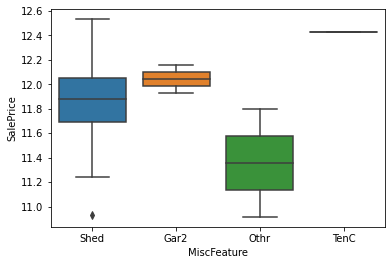

In [35]:
sns.boxplot(
    x = 'MiscFeature',
    y = 'SalePrice',
    data = df[~ df['SalePrice'].isna()]
)

We are replacing the missing Misc feature by "No"

In [37]:
df['MiscFeature'] = df['MiscFeature'].fillna('No')

<AxesSubplot:xlabel='MiscFeature', ylabel='SalePrice'>

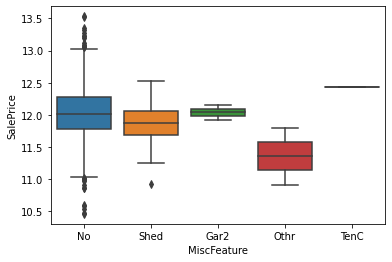

In [38]:
sns.boxplot(
    x = 'MiscFeature',
    y = 'SalePrice',
    data = df[~ df['SalePrice'].isna()]
)

### 1.2.3 Alley variable

In [40]:
print(f"The Alley contains the type of alley to the house, where a missing value means that there is not any alley. {np.round(missing_vals['Alley']/df.shape[0]*100,4)}% of the values are missing. It is an unordered factor.")

The Alley contains the type of alley to the house, where a missing value means that there is not any alley. 93.2169% of the values are missing. It is an unordered factor.


<AxesSubplot:xlabel='Alley', ylabel='SalePrice'>

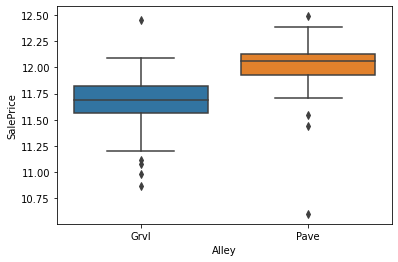

In [41]:
sns.boxplot(
    x = 'Alley',
    y = 'SalePrice',
    data = df[~ df['SalePrice'].isna()]
)

We replace the missing values by "No".

In [42]:
df['Alley'] = df['Alley'].fillna('No')

<AxesSubplot:xlabel='Alley', ylabel='SalePrice'>

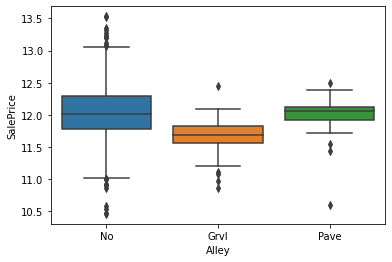

In [43]:
sns.boxplot(
    x = 'Alley',
    y = 'SalePrice',
    data = df[~ df['SalePrice'].isna()]
)

### 1.2.4 Fence variable

In [50]:
print(f"The Fence variable contains the type of fence around the house, where a missing value means that there is not any fence. {np.round(missing_vals['Fence']/df.shape[0]*100,4)}% of the values are missing. It is an unordered factor.")

The Fence variable contains the type of fence around the house, where a missing value means that there is not any fence. 80.4385% of the values are missing. It is an unordered factor.


<AxesSubplot:xlabel='Fence', ylabel='SalePrice'>

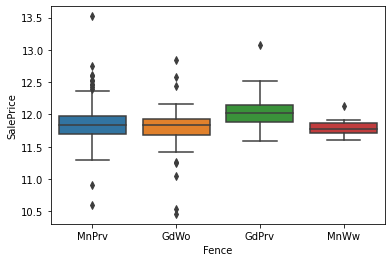

In [45]:
sns.boxplot(
    x = 'Fence',
    y = 'SalePrice',
    data = df[~ df['SalePrice'].isna()]
)

In [46]:
df['Fence'] = df['Fence'].fillna('No')

<AxesSubplot:xlabel='Fence', ylabel='SalePrice'>

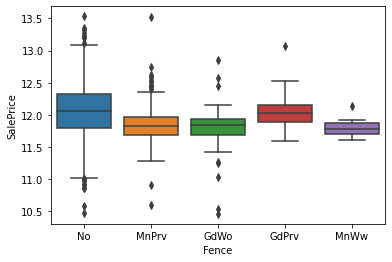

In [47]:
sns.boxplot(
    x = 'Fence',
    y = 'SalePrice',
    data = df[~ df['SalePrice'].isna()]
)

### 1.2.5 Fireplace
There are 2 variables relative to the fireplaces: Fireplaces, counting the number of fireplaces, and FireplaceQu for the fireplace quality.

In [49]:
print(f"The FireplaceQu variable has {np.round(missing_vals['FireplaceQu']/df.shape[0]*100,4)}% missing values. It is an ordered factor.")

The FireplaceQu variable has 48.6468% missing values. It is an ordered factor.


In [52]:
df[df['FireplaceQu'].isna()]['Fireplaces'].value_counts()

0    1420
Name: Fireplaces, dtype: int64

<AxesSubplot:xlabel='FireplaceQu', ylabel='SalePrice'>

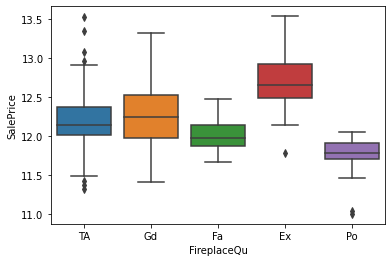

In [53]:
sns.boxplot(
    x = 'FireplaceQu',
    y = 'SalePrice',
    data = df[~ df['SalePrice'].isna()]
)

We replace the missing values by "No"

In [54]:
df['FireplaceQu'] = df['FireplaceQu'].fillna('No')

<AxesSubplot:xlabel='FireplaceQu', ylabel='SalePrice'>

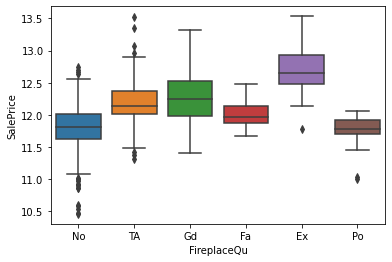

In [55]:
sns.boxplot(
    x = 'FireplaceQu',
    y = 'SalePrice',
    data = df[~ df['SalePrice'].isna()]
)

### 1.2.6 LotFrontage variable

In [57]:
print(f"The LotFrontage variable contains the linear feet of street connected to property. It is a numerical variable, with {np.round(missing_vals['LotFrontage']/df.shape[0]*100,4)}% missing values.")


The LotFrontage variable contains the linear feet of street connected to property. It is a numerical variable, with 16.6495% missing values.


<AxesSubplot:xlabel='LotFrontage', ylabel='SalePrice'>

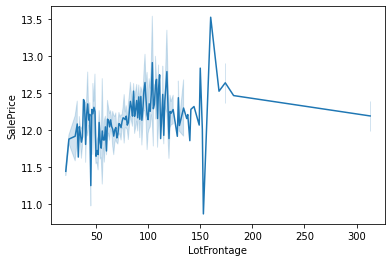

In [58]:
sns.lineplot(x = 'LotFrontage',y = 'SalePrice',data = df)

We will fill this variable with a KNN model

### 1.2.7 Garage variables
There are 7 variables related to houses' garages.

GarageCars and GarageArea have 1 missing value for the observation Id 2577. This house seems to not have any garage, thus we replace the values of these 2 predictors by 0 and remove the value in GarageType.


In [61]:
df.iloc[2576,:]

Id                 2577
MSSubClass           70
MSZoning             RM
LotFrontage        50.0
LotArea            9060
                  ...  
YrSold             2007
SaleType             WD
SaleCondition    Alloca
SalePrice           NaN
overall_fac          TA
Name: 2576, Length: 82, dtype: object

In [62]:
df['GarageType'] = np.where(
    df['GarageArea'].isna(),
    np.nan,
    df['GarageType']
)
df['GarageArea'] = df['GarageArea'].fillna(0)
df['GarageCars'] = df['GarageCars'].fillna(0)


In the rows when there is no garage, GarageCars and GarageArea are fixed to 0 and GarageType, GarageYrBlt, GarageFinish, GarageQual and GarageCond are missing. All 5 are ordered factors.

There is a row with Id 2127 where GarageYrBlt, GarageFinish, GarageQual and GarageCond are missing, but GarageArea > 0 and GarageType exists. 

Except for this row, the predictors GarageType, GarageFinish, GarageQual and GarageCond will be filled with a new value "No" and GarageYrBlt will be filled by the year the house was built.

We will fill the row 2127 with a knn method.


In [63]:
df['GarageYrBlt'] = np.where(
    df['GarageYrBlt'].isna() & df['Id'] != 2127,
    df['YearBuilt'],
    df['GarageYrBlt']
)
df['GarageType'] = df['GarageType'].fillna('No')
df['GarageFinish'] = df['GarageFinish'].fillna('No')
df['GarageQual'] = df['GarageQual'].fillna('No')
df['GarageCond'] = df['GarageCond'].fillna('No')

df[df['Id']==2127][['GarageYrBlt','GarageType','GarageFinish','GarageQual','GarageCond']] = np.nan

C:\Users\jsbin\AppData\Local\Temp\ipykernel_12260\2744137296.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df['Id']==2127][['GarageYrBlt','GarageType','GarageFinish','GarageQual','GarageCond']] = np.nan


### 1.2.8 Basement variables
There are 11 variables related to houses' basements, and all of them have missing values with different percentages:


In [64]:
for col in [col for col in df.columns if col.startswith('Bsmt')]:
    print(f"- There are {np.round(missing_vals[col]/df.shape[0]*100,4)}% missing values for variable {col}")

- There are 2.7749% missing values for variable BsmtQual
- There are 2.8092% missing values for variable BsmtCond
- There are 2.8092% missing values for variable BsmtExposure
- There are 2.7064% missing values for variable BsmtFinType1
- There are 0.0343% missing values for variable BsmtFinSF1
- There are 2.7407% missing values for variable BsmtFinType2
- There are 0.0343% missing values for variable BsmtFinSF2
- There are 0.0343% missing values for variable BsmtUnfSF
- There are 0.0685% missing values for variable BsmtFullBath
- There are 0.0685% missing values for variable BsmtHalfBath


All of these predictors are either ordered factors or numerical.

The row with Id 2121 is NA for all basement variables. We replace the numerical values by 0 and the factor ones by "No".

The row with Id 2189 is the other one with NA for the variables related to Bathrooms in the basement. We replace them with 0.

The rows with Id 2041, 2186 and 2525 contain missing values only for BsmtCond. We replace them with the values in BsmtQual, which are average.

The rows with Id 949, 1488 and 2349 contain missing values only for BsmtExposure. Since for these profiles the BsmtQual and BsmtCond are average, we replace them with the "Av" value.


All other rows, we consider that there is no basement. We replace the missing value by "No" except for BsmtExposure where we will replace it with "None" since the value "No" already exists.


In [ ]:
for col in ['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath']:
    df[col] = df[col].fillna(0)

df['BsmtCond'] = np.where(
    (df['BsmtCond'].isna()) & (~ df['BsmtQual'].isna()),
    df['BsmtQual'],
    df['BsmtCond']
)
df['BsmtQual'] = df['BsmtQual'].fillna('No')
df['BsmtCond'] = df['BsmtCond'].fillna('No')


# Stopped at line 431 or the EDA.Rmd file.